In [ ]:
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
THRESHOLD_MISSING = 5
THRESHOLD_CORRELATION = 0.90

def clean_FAOSTAT(df):
    #keep data only from FAO TIER 1 source, original data contains data for same year but from multiple sources
    #both sources have similar measurements
    #FAO TIER 1 is more complete than UNFCCC
    cleaned_df = df[df["Source Code"] == 3050] #FAO TIER 1
    #drop numeric codes that do not apply
    cleaned_df = cleaned_df.drop(['Area Code', 'Item Code', 'Source Code', 'Source', 'Element Code'], axis=1)
    #extract columns belonging to the USA
    cleaned_df = cleaned_df[cleaned_df['Area'] == 'United States of America']
    #rename Items column to Activity
    cleaned_df.rename(columns={'Item':'Activity'}, inplace=True)
    #reset the index
    cleaned_df = cleaned_df.reset_index(drop=True)
    return cleaned_df

#Clean up the emissions dataframe consisting of only emission activity/element and year
def create_emissions_frame(columns, df):
    df['Emission'] = df[columns[0]].astype(str) + '_' + df[columns[1]]
    df.drop(columns, axis=1, inplace=True)
    df.insert(0,'Emission', df.pop('Emission'))
    df = drop_year_no_data(df)
    df = df.set_index('Emission').transpose().fillna(0).reset_index()
    df['index'] = df['index'].str.lstrip('Y')
    return df.rename(columns={'index':'Year'}).set_index('Year')

#filter the emissions list to only contain the biggest contributers to argiculture
def list_emissions(emission_name, emission_activity_and_type):
    return list(filter(lambda emission: emission_name in emission[1],emission_activity_and_type))

#Because Area and Unit are the same value in every row (USA, Kilotonnes respectively), I will drop those. Set the column indicies to Activity
def create_emission_df(df, emission_list):
    return df[df['Element'].isin([el[1] for el in emission_list])].drop(['Area', 'Unit'], axis=1).reset_index(drop=True)

#drop columns where more than THRESHOLD_MISSING % of data is missing
def drop_year_no_data(df):
    #df columns currently are Year 19XX/2XXX
    for column in df:
        #if there is too much data missing for a particular year, drop it
        #initial check showed most data prior to 1990 is missing & is effectively being dropped
        if check_percent_data_missing(df[column]) > THRESHOLD_MISSING:
            df.drop(column, axis=1, inplace=True)
    return df

#check % of data missing in each column
def check_percent_data_missing(df):
    return df.isnull().sum()/df.shape[0] * 100

#a lot of data in set relates to emissions due to fires, keep emissions only related to agriculture
def keep_agriculture_data(df):
    columns_to_keep = []
    for column in df:
        if "agricult" in str(column).lower() or "farm" in str(column).lower():
            columns_to_keep.append(str(column))
    cleaned_df = df[columns_to_keep]
    return cleaned_df

#a lot of data in set relates to emissions due to fires, keep emissions only related to agriculture
def remove_fire_data(df):
    for column in df:
        #LULUCF emissions are a metric of how much emissions are sunk by forests
        if "fire" in str(column).lower() or "burn" in str(column).lower() or "forest" in str(column).lower() or "LULUCF" in str(column).lower():
            df.drop(column, axis=1, inplace=True)
    return df

def visualize_column(column, label_y, title):
    plt.plot(column.index, column)
    plt.xlabel("Year")
    axes = plt.axes()
    axes.xaxis.set_major_locator(plt.MaxNLocator(10))
    plt.ylabel(label_y)
    plt.title(title)
    plt.show()

def drop_correlations(df):
    # create correlation matrix
    corr_matrix = df.corr().abs()
    # select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # find features with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > THRESHOLD_CORRELATION)]
    df.drop(to_drop, axis=1, inplace=True)
    return df

#random testing, add things here
def do_random_prints_and_testing(CO2_df, CH4_df, N2O_df):
    print("CO2 columns ", CO2_df.columns)
    print("CH4 columns ", CH4_df.columns)
    print("N2O columns ", N2O_df.columns)
    print(CO2_df.loc[CO2_df.index[0]])
    print(CH4_df.loc[CH4_df.index[0]])
    print(N2O_df.loc[N2O_df.index[0]])
    visualize_column(CO2_df.iloc[:, 1], str(CO2_df.columns[1]), str(CO2_df.columns[1]) + " over Time")
    visualize_column(CO2_df.iloc[:, 2], str(CO2_df.columns[2]), str(CO2_df.columns[2]) + " over Time")

In [ ]:
prod_amt=pd.read_csv('clean_production.csv')
prod_amt.drop(columns=['Unnamed: 0'],inplace=True)
prod_amt.rename(columns={"YEAR":"Year"},inplace=True)
# prod_amt.set_index('Year',inplace=True)
#       prod_amt.drop([2020,2021,2022,2023,2024,2025,2026],axis=0,inplace=True)
# prod_amt.index = pd.to_datetime(prod_amt.index, format='%Y')
# prod_amt.astype({'Year': 'object'})
prod_amt['Year']=prod_amt['Year'].astype("str")
# prod_amt.reset_index(drop=True, inplace=True)
prod_amt.head(3)

,Year,RICE_TONNE_HA,RICE_THND_TONNE,RICE_THND_HA,WHEAT_TONNE_HA,WHEAT_THND_TONNE,WHEAT_THND_HA,MAIZE_TONNE_HA,MAIZE_THND_TONNE,MAIZE_THND_HA,SOYBEAN_TONNE_HA,SOYBEAN_THND_TONNE,SOYBEAN_THND_HA
0,1990,4.313679,4928.082909,1142.431401,2.656879,74296.9584,27964.0,7.433033,201539.468,27114.0290,2.292400,52415.2944,22864.815500
1,1991,4.468591,5029.107031,1125.434547,2.303895,53890.4016,23391.0,6.819797,189879.950,27842.4656,2.303380,54064.5840,23471.846000
2,1992,4.473428,5669.978799,1267.479684,2.641679,67136.4288,25414.3,8.250576,240734.754,29177.9327,2.529181,59603.0400,23566.138071


<ipython-input-2-0246aa8b0dad>:83: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
<ipython-input-2-0246aa8b0dad>:73: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axes = plt.axes()


CO2 columns  Index(['Enteric Fermentation_Emissions (CO2eq) from CH4 (AR5)',
       'Manure Management_Emissions (CO2eq) from CH4 (AR5)',
       'Manure Management_Emissions (CO2eq) from N2O (AR5)',
       'Rice Cultivation_Emissions (CO2eq) from CH4 (AR5)',
       'Synthetic Fertilizers_Emissions (CO2eq) from N2O (AR5)',
       'Manure applied to Soils_Emissions (CO2eq) from N2O (AR5)',
       'Crop Residues_Emissions (CO2eq) from N2O (AR5)',
       'On-farm energy use_Emissions (CO2)',
       'On-farm energy use_Emissions (CO2eq) from CH4 (AR5)',
       'On-farm energy use_Emissions (CO2eq) from N2O (AR5)',
       'IPCC Agriculture_Emissions (CO2eq) from N2O (AR5)',
       'IPCC Agriculture_Emissions (CO2eq) (AR5)', 'LULUCF_Emissions (CO2)',
       'AFOLU_Emissions (CO2eq) from CH4 (AR5)',
       'Emissions on agricultural land_Emissions (CO2)',
       'Farm-gate emissions_Emissions (CO2eq) (AR5)'],
      dtype='object', name='Emission')
CH4 columns  Index(['Enteric Fermentation_Emis

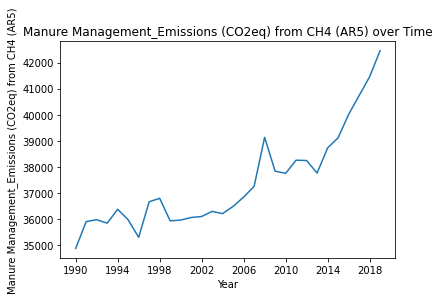

<ipython-input-2-0246aa8b0dad>:73: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axes = plt.axes()


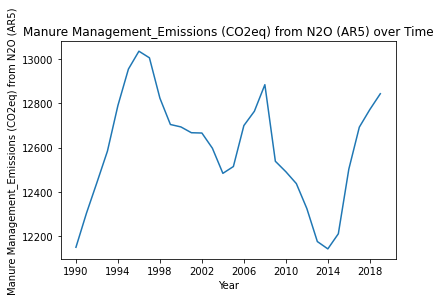

In [ ]:

import pandas as pd

df = pd.read_csv('FAOSTAT_data_1961_2019.csv')
cleaned_df = clean_FAOSTAT(df)

#create an emission activity and emission type list. Each value is a tuple, 0th -> activity, 1st -> type of emission
emission_activity_and_type = list(cleaned_df.groupby(['Activity','Element']).indices.keys())

'''Anthropogenic climate change is caused by multiple climate pollutants, with CO2, CH4, and N2O the three largest individual contributors to global warming. Agriculture and food production is associated with all three of these gases, but direct agricultural emissions are unusual in being dominated by CH4 and N2O.'''

#filter the emissions list to only contain the biggest contributers to argiculture
CO2_gas_list = list_emissions("CO2", emission_activity_and_type)
CH4_gas_list = list_emissions("CH4", emission_activity_and_type)
N2O_gas_list = list_emissions("N2O", emission_activity_and_type)

#Because Area and Unit are the same value in every row (USA, Kilotonnes respectively), I will drop those. Set the column indicies to Activity
CO2_df = create_emission_df(cleaned_df, CO2_gas_list)
CH4_df = create_emission_df(cleaned_df, CH4_gas_list)
N2O_df = create_emission_df(cleaned_df, N2O_gas_list)

#filter the emissions list to only contain the biggest contributers to argiculture
CO2_df = create_emissions_frame(['Activity', 'Element'], CO2_df)
CH4_df = create_emissions_frame(['Activity', 'Element'], CH4_df)
N2O_df = create_emissions_frame(['Activity', 'Element'], N2O_df)

#drop highly correlated features
CO2_df = drop_correlations(CO2_df)
CH4_df = drop_correlations(CH4_df)
N2O_df = drop_correlations(N2O_df)

# #focus on agriculture
# CO2_df = keep_agriculture_data(CO2_df)
# CH4_df = keep_agriculture_data(CH4_df)
# N2O_df = keep_agriculture_data(N2O_df)

#the features that remain are not related to forests and fires but agrivulture
#all features have a correlation less than abs(THRESHOLD_CORRELATION)
CO2_df = remove_fire_data(CO2_df)
CH4_df = remove_fire_data(CH4_df)
N2O_df = remove_fire_data(N2O_df)
do_random_prints_and_testing(CO2_df, CH4_df, N2O_df)

In [ ]:
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

#df_all_data = pd.merge(df_dow, df_headlines, on='Date')
prod_amt=prod_amt.merge(CO2_df,on='Year')

In [ ]:
prod_amt.head(1)

,Year,RICE_TONNE_HA,RICE_THND_TONNE,RICE_THND_HA,WHEAT_TONNE_HA,WHEAT_THND_TONNE,WHEAT_THND_HA,MAIZE_TONNE_HA,MAIZE_THND_TONNE,MAIZE_THND_HA,...,Crop Residues_Emissions (CO2eq) from N2O (AR5),On-farm energy use_Emissions (CO2),On-farm energy use_Emissions (CO2eq) from CH4 (AR5),On-farm energy use_Emissions (CO2eq) from N2O (AR5),IPCC Agriculture_Emissions (CO2eq) from N2O (AR5),IPCC Agriculture_Emissions (CO2eq) (AR5),LULUCF_Emissions (CO2),AFOLU_Emissions (CO2eq) from CH4 (AR5),Emissions on agricultural land_Emissions (CO2),Farm-gate emissions_Emissions (CO2eq) (AR5)
0,1990,4.313679,4928.082909,1142.431401,2.656879,74296.9584,27964.0,7.433033,201539.468,27114.029,...,19193.1314,50419.342,575.1024,3460.2557,143043.428,363642.0492,-345907.2702,245765.281,225085.2312,459005.2738


In [ ]:
#drop last three years so all data matches
CO2_df.drop(CO2_df.tail(3).index,inplace=True)
CH4_df.drop(CH4_df.tail(3).index,inplace=True)
N2O_df.drop(N2O_df.tail(3).index,inplace=True)
#splitting the data
from sklearn.model_selection import train_test_split
CO2_df = CO2_df.reset_index(drop=False)

c02_prod=pd.merge(prod_amt, CO2_df, left_index=True, right_index=True)
# prod_amt.merge(N2O_df, on="Year")

In [ ]:
CH4_df = CH4_df.reset_index(drop=False)
ch4_prod=pd.merge(prod_amt, CH4_df, left_index=True, right_index=True)

In [ ]:
N2O_df = N2O_df.reset_index(drop=False)
n20_prod=pd.merge(prod_amt, N2O_df, left_index=True, right_index=True)

In [ ]:
# c02_prod.drop(columns=['level_0','Year_y','index'],inplace=True) #done
c02_prod.drop(columns=['Year_y'],inplace=True)

In [ ]:
c02_prod.iloc[:,13:].head(2)

,Enteric Fermentation_Emissions (CO2eq) from CH4 (AR5)_x,Manure Management_Emissions (CO2eq) from CH4 (AR5)_x,Manure Management_Emissions (CO2eq) from N2O (AR5)_x,Rice Cultivation_Emissions (CO2eq) from CH4 (AR5)_x,Synthetic Fertilizers_Emissions (CO2eq) from N2O (AR5)_x,Manure applied to Soils_Emissions (CO2eq) from N2O (AR5)_x,Crop Residues_Emissions (CO2eq) from N2O (AR5)_x,On-farm energy use_Emissions (CO2)_x,On-farm energy use_Emissions (CO2eq) from CH4 (AR5)_x,On-farm energy use_Emissions (CO2eq) from N2O (AR5)_x,...,Crop Residues_Emissions (CO2eq) from N2O (AR5)_y,On-farm energy use_Emissions (CO2)_y,On-farm energy use_Emissions (CO2eq) from CH4 (AR5)_y,On-farm energy use_Emissions (CO2eq) from N2O (AR5)_y,IPCC Agriculture_Emissions (CO2eq) from N2O (AR5)_y,IPCC Agriculture_Emissions (CO2eq) (AR5)_y,LULUCF_Emissions (CO2)_y,AFOLU_Emissions (CO2eq) from CH4 (AR5)_y,Emissions on agricultural land_Emissions (CO2)_y,Farm-gate emissions_Emissions (CO2eq) (AR5)_y
0,170822.988,34876.1432,12148.5592,11195.520,56149.3898,13156.7724,19193.1314,50419.3420,575.1024,3460.2557,...,19193.1314,50419.3420,575.1024,3460.2557,143043.4280,363642.0492,-345907.2702,245765.2810,225085.2312,459005.2738
1,171455.046,35903.5113,12302.5338,11029.312,57032.6889,13370.9850,17574.1126,50510.0919,570.3426,3485.1641,...,17574.1126,50510.0919,570.3426,3485.1641,142908.1249,364920.2282,-345907.2702,247178.7631,225175.9811,460394.3514


In [ ]:
c02_prod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27 entries, 0 to 26
Data columns (total 45 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Year_x                                                      27 non-null     object 
 1   RICE_TONNE_HA                                               27 non-null     float64
 2   RICE_THND_TONNE                                             27 non-null     float64
 3   RICE_THND_HA                                                27 non-null     float64
 4   WHEAT_TONNE_HA                                              27 non-null     float64
 5   WHEAT_THND_TONNE                                            27 non-null     float64
 6   WHEAT_THND_HA                                               27 non-null     float64
 7   MAIZE_TONNE_HA                                              27 non-null     float64
 8   MA

In [ ]:
ch4_prod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27 entries, 0 to 26
Data columns (total 35 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Year_x                                                    27 non-null     object 
 1   RICE_TONNE_HA                                             27 non-null     float64
 2   RICE_THND_TONNE                                           27 non-null     float64
 3   RICE_THND_HA                                              27 non-null     float64
 4   WHEAT_TONNE_HA                                            27 non-null     float64
 5   WHEAT_THND_TONNE                                          27 non-null     float64
 6   WHEAT_THND_HA                                             27 non-null     float64
 7   MAIZE_TONNE_HA                                            27 non-null     float64
 8   MAIZE_THND_TONNE      

In [ ]:
n20_prod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27 entries, 0 to 26
Data columns (total 38 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Year_x                                                    27 non-null     object 
 1   RICE_TONNE_HA                                             27 non-null     float64
 2   RICE_THND_TONNE                                           27 non-null     float64
 3   RICE_THND_HA                                              27 non-null     float64
 4   WHEAT_TONNE_HA                                            27 non-null     float64
 5   WHEAT_THND_TONNE                                          27 non-null     float64
 6   WHEAT_THND_HA                                             27 non-null     float64
 7   MAIZE_TONNE_HA                                            27 non-null     float64
 8   MAIZE_THND_TONNE      

In [ ]:
n20_prod.iloc[:,1:12].head(2)

,RICE_TONNE_HA,RICE_THND_TONNE,RICE_THND_HA,WHEAT_TONNE_HA,WHEAT_THND_TONNE,WHEAT_THND_HA,MAIZE_TONNE_HA,MAIZE_THND_TONNE,MAIZE_THND_HA,SOYBEAN_TONNE_HA,SOYBEAN_THND_TONNE
0,4.313679,4928.082909,1142.431401,2.656879,74296.9584,27964.0,7.433033,201539.468,27114.0290,2.29240,52415.2944
1,4.468591,5029.107031,1125.434547,2.303895,53890.4016,23391.0,6.819797,189879.950,27842.4656,2.30338,54064.5840


Danny-Linear Regression

In [ ]:
from sklearn.preprocessing import MinMaxScaler
X_1=n20_prod[['Enteric Fermentation_Emissions (CO2eq) from CH4 (AR5)','On-farm energy use_Emissions (CO2)','On-farm energy use_Emissions (CO2eq) from CH4 (AR5)','On-farm energy use_Emissions (CO2eq) from N2O (AR5)',
'Emissions on agricultural land_Emissions (CO2)','On-farm energy use_Emissions (N2O)','IPCC Agriculture_Emissions (CO2eq) from N2O (AR5)','IPCC Agriculture_Emissions (CO2eq) (AR5)']]

# X_1=n20_prod[['Enteric Fermentation_Emissions (CO2eq) from CH4 (AR5)','On-farm energy use_Emissions (CO2eq) from CH4 (AR5)',
#               'On-farm energy use_Emissions (CO2eq) from N2O (AR5)',
# 'On-farm energy use_Emissions (N2O)','IPCC Agriculture_Emissions (CO2eq) from N2O (AR5)']]
y_1=n20_prod[['RICE_TONNE_HA','WHEAT_TONNE_HA','MAIZE_TONNE_HA','SOYBEAN_TONNE_HA']]
from sklearn.preprocessing import StandardScaler
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size = 0.2, random_state = 21)
sc = StandardScaler()
X_1_train = sc.fit_transform(X_1_train)
X_1_test = sc.transform(X_1_test)

In [ ]:
regr = LinearRegression()
  
regr.fit(X_1_train, y_1_train)
y_1_pred=regr.predict(X_1_test)
print(regr.score(X_1_test, y_1_test))#r^2 score

0.7579197425767624


In [ ]:
import math
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_1_test, y_1_pred))
print(math.sqrt(mean_squared_error(y_1_test, y_1_pred)))
# MSE: 109.86374118394116
# RMSE: 10.48159058463653

0.15954426213636844
0.39942992143349554


In [ ]:
from sklearn.metrics import r2_score
print(r2_score(y_1_test, y_1_pred))

0.7579197425767624


Linear regression - Kristina <br>
Adding multiple entries in merged data frame <br>
Results  are better with 100x larger data set

In [ ]:
import pandas as pd
import numpy as np
n20_prod_extended = pd.DataFrame(np.repeat(n20_prod.values, 100, axis=0))
n20_prod_extended.columns = n20_prod.columns


In [ ]:
from sklearn.preprocessing import MinMaxScaler
# X_2=n20_prod_extended[['Enteric Fermentation_Emissions (CO2eq) from CH4 (AR5)','On-farm energy use_Emissions (CO2)','On-farm energy use_Emissions (CO2eq) from CH4 (AR5)','On-farm energy use_Emissions (CO2eq) from N2O (AR5)',
# 'Emissions on agricultural land_Emissions (CO2)','On-farm energy use_Emissions (N2O)','IPCC Agriculture_Emissions (CO2eq) from N2O (AR5)','IPCC Agriculture_Emissions (CO2eq) (AR5)']]
X_2=n20_prod_extended[['Manure Management_Emissions (N2O)',
				'Synthetic Fertilizers_Direct emissions (N2O)',
				'On-farm energy use_Emissions (N2O)',
				'Crop Residues_Direct emissions (N2O)',
				'IPCC Agriculture_Direct emissions (N2O)']]
# X_1=n20_prod[['Enteric Fermentation_Emissions (CO2eq) from CH4 (AR5)','On-farm energy use_Emissions (CO2eq) from CH4 (AR5)',
#               'On-farm energy use_Emissions (CO2eq) from N2O (AR5)',
# 'On-farm energy use_Emissions (N2O)','IPCC Agriculture_Emissions (CO2eq) from N2O (AR5)']]
y_2=n20_prod_extended[['RICE_TONNE_HA','WHEAT_TONNE_HA','MAIZE_TONNE_HA','SOYBEAN_TONNE_HA']]
from sklearn.preprocessing import StandardScaler
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size = 0.2, random_state = 21)
sc = StandardScaler()
X_2_train = sc.fit_transform(X_2_train)
X_2_test = sc.transform(X_2_test)
regr = LinearRegression()
regr.fit(X_2_train, y_2_train)
y_2_pred=regr.predict(X_2_test)
print(regr.score(X_2_test, y_2_test))#r^2 score

0.8229829673819015


In [ ]:
import math
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_2_test, y_2_pred))
print(math.sqrt(mean_squared_error(y_2_test, y_2_pred)))
# MSE: 109.86374118394116
# RMSE: 10.48159058463653

0.07554912873052723
0.2748620176207095


In [ ]:
from sklearn.metrics import r2_score
print(r2_score(y_2_test, y_2_pred))

0.8255576820613176


Adding noise - Kristina

In [ ]:
import pandas as pd
import numpy as np
print(n20_prod.shape)
n20_prod_extended = pd.DataFrame(np.repeat(n20_prod.values, 1000, axis=0))
n20_prod_extended.columns = n20_prod.columns
print(n20_prod_extended.shape)

(27, 38)
(27000, 38)


In [ ]:
import numpy as np 
mu, sigma = 0, 0.1 
noise = np.random.normal(mu, sigma, [n20_prod_extended.shape[0],n20_prod_extended.shape[1]])
print(noise.dtype)
n20_prod_noisy = n20_prod_extended.astype(float) + noise

float64


In [ ]:
from sklearn.preprocessing import MinMaxScaler
X_2=n20_prod_extended[['Enteric Fermentation_Emissions (CO2eq) from CH4 (AR5)','On-farm energy use_Emissions (CO2)','On-farm energy use_Emissions (CO2eq) from CH4 (AR5)','On-farm energy use_Emissions (CO2eq) from N2O (AR5)',
'Emissions on agricultural land_Emissions (CO2)','On-farm energy use_Emissions (N2O)','IPCC Agriculture_Emissions (CO2eq) from N2O (AR5)','IPCC Agriculture_Emissions (CO2eq) (AR5)']]

# X_1=n20_prod[['Enteric Fermentation_Emissions (CO2eq) from CH4 (AR5)','On-farm energy use_Emissions (CO2eq) from CH4 (AR5)',
#               'On-farm energy use_Emissions (CO2eq) from N2O (AR5)',
# 'On-farm energy use_Emissions (N2O)','IPCC Agriculture_Emissions (CO2eq) from N2O (AR5)']]
y_2=n20_prod_extended[['RICE_TONNE_HA','WHEAT_TONNE_HA','MAIZE_TONNE_HA','SOYBEAN_TONNE_HA']]
from sklearn.preprocessing import StandardScaler
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size = 0.2, random_state = 21)
sc = StandardScaler()
X_2_train = sc.fit_transform(X_2_train)
X_2_test = sc.transform(X_2_test)
regr = LinearRegression()
regr.fit(X_2_train, y_2_train)
y_2_pred=regr.predict(X_2_test)
print(regr.score(X_2_test, y_2_test))#r^2 score

0.8234627667132697


Linear regression - Kristina <br>
Adding cross validation and a larger data set <br>
Model accuracy with a larger data set + CV doesn't improve much, so we can leave it out

In [ ]:
from sklearn.preprocessing import MinMaxScaler
X_3=n20_prod_extended[['Enteric Fermentation_Emissions (CO2eq) from CH4 (AR5)','On-farm energy use_Emissions (CO2)','On-farm energy use_Emissions (CO2eq) from CH4 (AR5)','On-farm energy use_Emissions (CO2eq) from N2O (AR5)',
'Emissions on agricultural land_Emissions (CO2)','On-farm energy use_Emissions (N2O)','IPCC Agriculture_Emissions (CO2eq) from N2O (AR5)','IPCC Agriculture_Emissions (CO2eq) (AR5)']]

# X_1=n20_prod[['Enteric Fermentation_Emissions (CO2eq) from CH4 (AR5)','On-farm energy use_Emissions (CO2eq) from CH4 (AR5)',
#               'On-farm energy use_Emissions (CO2eq) from N2O (AR5)',
# 'On-farm energy use_Emissions (N2O)','IPCC Agriculture_Emissions (CO2eq) from N2O (AR5)']]
y_3=n20_prod_extended[['RICE_TONNE_HA','WHEAT_TONNE_HA','MAIZE_TONNE_HA','SOYBEAN_TONNE_HA']]
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X_3, y_3, test_size = 0.2, random_state = 21)
sc = StandardScaler()
X_3_train = sc.fit_transform(X_3_train)
X_3_test = sc.transform(X_3_test)
kf = KFold(n_splits=10, shuffle=True, random_state=21)
regr = LinearRegression()
cv_results = cross_val_score(regr, X_3_train, y_3_train, cv=kf)
print(cv_results)

[0.83887022 0.81344617 0.83149283 0.81764948 0.81029809 0.79548793
 0.82998491 0.81707969 0.82981676 0.82054265]


co2 lin reg

In [ ]:
from sklearn.preprocessing import MinMaxScaler
X=c02_prod.iloc[:,13:]
#target
y=c02_prod.iloc[:,1:12]#[['RICE_TONNE_HA']]#,'WHEAT_THND_TONNE','MAIZE_THND_TONNE','SOYBEAN_THND_TONNE']]

from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 21)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
regr = LinearRegression()
  
regr.fit(X_train, y_train)
y_pred=regr.predict(X_test)
print(regr.score(X_test, y_test))

-1.202852216139968


In [ ]:
import math
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, y_pred))
print(math.sqrt(mean_squared_error(y_test, y_pred)))

63554778.67689111
7972.125104192176


In [ ]:
from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))

-1.202852216139968


CO2 linear regression - larger data set

In [ ]:
import pandas as pd
import numpy as np
c02_prod_extended = pd.DataFrame(np.repeat(c02_prod.values, 100, axis=0))
c02_prod_extended.columns = c02_prod.columns

In [ ]:
from sklearn.preprocessing import MinMaxScaler
X_2=c02_prod_extended.iloc[:,13:]
#target
y_2=c02_prod_extended.iloc[:,1:12]#[['RICE_TONNE_HA']]#,'WHEAT_THND_TONNE','MAIZE_THND_TONNE','SOYBEAN_THND_TONNE']]

from sklearn.preprocessing import StandardScaler
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size = 0.3, random_state = 21)
sc = StandardScaler()
X_2_train = sc.fit_transform(X_2_train)
X_2_test = sc.transform(X_2_test)
regr = LinearRegression()
regr.fit(X_2_train, y_2_train)
y_2_pred=regr.predict(X_2_test)
print(regr.score(X_2_test, y_2_test))#r^2 score

0.9489763589634901


In [ ]:
import math
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_2_test, y_2_pred))
print(math.sqrt(mean_squared_error(y_2_test, y_2_pred)))

2944829.992894465
1716.0506964814488


In [ ]:
from sklearn.metrics import r2_score
print(r2_score(y_2_test, y_2_pred))

0.9489763589634901


In [ ]:
ch4_prod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27 entries, 0 to 26
Data columns (total 35 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Year_x                                                    27 non-null     object 
 1   RICE_TONNE_HA                                             27 non-null     float64
 2   RICE_THND_TONNE                                           27 non-null     float64
 3   RICE_THND_HA                                              27 non-null     float64
 4   WHEAT_TONNE_HA                                            27 non-null     float64
 5   WHEAT_THND_TONNE                                          27 non-null     float64
 6   WHEAT_THND_HA                                             27 non-null     float64
 7   MAIZE_TONNE_HA                                            27 non-null     float64
 8   MAIZE_THND_TONNE      

ch4 lin reg

In [ ]:
# X=ch4_prod.iloc[:,13:]
X=ch4_prod[['On-farm energy use_Emissions (CH4)','IPCC Agriculture_Emissions (CO2eq) from N2O (AR5)','Emissions on agricultural land_Emissions (CO2)','Enteric Fermentation_Emissions (CH4)','Farm-gate emissions_Emissions (CO2eq) (AR5)']]
#target
y=ch4_prod[['RICE_TONNE_HA','WHEAT_TONNE_HA','MAIZE_TONNE_HA','SOYBEAN_TONNE_HA']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 21)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
y_train = sc.fit_transform(y_train)
y_test = sc.transform(y_test)

In [ ]:
regr = LinearRegression()
  
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

0.7392566477705271


Linear regression - CH4 larger data set

In [ ]:
import pandas as pd
import numpy as np
ch4_prod_extended = pd.DataFrame(np.repeat(ch4_prod.values, 100, axis=0))
ch4_prod_extended.columns = ch4_prod.columns

In [ ]:
from sklearn.preprocessing import MinMaxScaler
X_2=ch4_prod_extended.iloc[:,13:]
#target
y_2=ch4_prod_extended.iloc[:,1:12]#[['RICE_TONNE_HA']]#,'WHEAT_THND_TONNE','MAIZE_THND_TONNE','SOYBEAN_THND_TONNE']]

from sklearn.preprocessing import StandardScaler
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size = 0.3, random_state = 21)
sc = StandardScaler()
X_2_train = sc.fit_transform(X_2_train)
X_2_test = sc.transform(X_2_test)
regr = LinearRegression()
regr.fit(X_2_train, y_2_train)
y_2_pred=regr.predict(X_2_test)
print(regr.score(X_2_test, y_2_test))#r^2 score

0.9751746702323921


In [ ]:
import math
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_2_test, y_2_pred))
print(math.sqrt(mean_squared_error(y_2_test, y_2_pred)))

1614961.321975725
1270.8112849576546


In [ ]:
from sklearn.metrics import r2_score
print(r2_score(y_2_test, y_2_pred))

0.9751746702323921


n20

In [ ]:
X=n20_prod.iloc[:,13:]
#target
y=n20_prod[['RICE_TONNE_HA','WHEAT_TONNE_HA','MAIZE_TONNE_HA','SOYBEAN_TONNE_HA']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 21)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
y_train = sc.fit_transform(y_train)
y_test = sc.transform(y_test)

In [ ]:
regr = LinearRegression()
  
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

-16.931230672734642


In [ ]:
ch4_prod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27 entries, 0 to 26
Data columns (total 35 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Year_x                                                    27 non-null     object 
 1   RICE_TONNE_HA                                             27 non-null     float64
 2   RICE_THND_TONNE                                           27 non-null     float64
 3   RICE_THND_HA                                              27 non-null     float64
 4   WHEAT_TONNE_HA                                            27 non-null     float64
 5   WHEAT_THND_TONNE                                          27 non-null     float64
 6   WHEAT_THND_HA                                             27 non-null     float64
 7   MAIZE_TONNE_HA                                            27 non-null     float64
 8   MAIZE_THND_TONNE      

In [ ]:
ch4_prod.head(2)

,Year_x,RICE_TONNE_HA,RICE_THND_TONNE,RICE_THND_HA,WHEAT_TONNE_HA,WHEAT_THND_TONNE,WHEAT_THND_HA,MAIZE_TONNE_HA,MAIZE_THND_TONNE,MAIZE_THND_HA,SOYBEAN_TONNE_HA,SOYBEAN_THND_TONNE,SOYBEAN_THND_HA,Year_y,Enteric Fermentation_Emissions (CH4),Manure Management_Emissions (CH4),Rice Cultivation_Emissions (CH4),On-farm energy use_Emissions (CH4),AFOLU_Emissions (CH4)
0,1990,4.313679,4928.082909,1142.431401,2.656879,74296.9584,27964.0,7.433033,201539.468,27114.0290,2.29240,52415.2944,22864.8155,1990,6100.8210,1245.5765,399.840,20.5394,8777.3315
1,1991,4.468591,5029.107031,1125.434547,2.303895,53890.4016,23391.0,6.819797,189879.950,27842.4656,2.30338,54064.5840,23471.8460,1991,6123.3945,1282.2683,393.904,20.3694,8827.8130


bayseain ridge

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
c02_prod.iloc[:,1:12].head(2)

,RICE_TONNE_HA,RICE_THND_TONNE,RICE_THND_HA,WHEAT_TONNE_HA,WHEAT_THND_TONNE,WHEAT_THND_HA,MAIZE_TONNE_HA,MAIZE_THND_TONNE,MAIZE_THND_HA,SOYBEAN_TONNE_HA,SOYBEAN_THND_TONNE
0,4.313679,4928.082909,1142.431401,2.656879,74296.9584,27964.0,7.433033,201539.468,27114.0290,2.29240,52415.2944
1,4.468591,5029.107031,1125.434547,2.303895,53890.4016,23391.0,6.819797,189879.950,27842.4656,2.30338,54064.5840


In [ ]:
X=c02_prod.iloc[:,13:]
#target
y=c02_prod.iloc[:,1:12]#[['RICE_TONNE_HA']]#,'WHEAT_THND_TONNE','MAIZE_THND_TONNE','SOYBEAN_THND_TONNE']]

from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 21)
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

In [ ]:
rdg=Ridge(alpha=2.0).fit(X_train,y_train)

In [ ]:
print(rdg.score(X_train, y_train))
print(rdg.score(X_test, y_test))

0.9737884287684321
0.4086132045327217


In [ ]:
from sklearn.metrics import mean_squared_error
ypred = rdg.predict(X_test)
mse = mean_squared_error(y_test, ypred)
print("MSE: %.2f" % mse)
rmse = mse**.5
print(rmse)

MSE: 26259302.98
5124.383180338489


Bayesian ridge - large data set

In [ ]:
import pandas as pd
import numpy as np
c02_prod_extended = pd.DataFrame(np.repeat(c02_prod.values, 100, axis=0))
c02_prod_extended.columns = c02_prod.columns

In [ ]:
from sklearn.linear_model import Ridge
X=c02_prod_extended.iloc[:,13:]
#target
y=c02_prod_extended.iloc[:,1:12]#[['RICE_TONNE_HA']]#,'WHEAT_THND_TONNE','MAIZE_THND_TONNE','SOYBEAN_THND_TONNE']]

from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 21)
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)
rdg=Ridge(alpha=2.0).fit(X_train,y_train)
print(rdg.score(X_train, y_train))
print(rdg.score(X_test, y_test))

0.9491789260321581
0.9491417486609106


In [ ]:
from sklearn.metrics import mean_squared_error
ypred = rdg.predict(X_test)
mse = mean_squared_error(y_test, ypred)
print("MSE: %.2f" % mse)
rmse = mse**.5
print(rmse)

MSE: 2879671.69
1696.9595429680085


ValueError: ignored

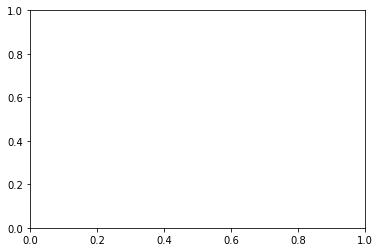

In [ ]:
import matplotlib.pyplot as plt
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, rdg, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show() 

In [ ]:
print(len(y_test))
print(len(x_ax))

5
5
